<a href="https://colab.research.google.com/github/diogopaz/projeto-marvel/blob/1%C2%B0's_insights/projeto_marvel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [1]:
!pip install dotenv

In [3]:
import requests
import hashlib
import time
import os
import pandas as pd
from dotenv import load_dotenv
import sqlite3
from google.colab import userdata


# Carregando variáveis de ambiente
Estamos fazendo upload do arquivo .env com as chaves de acesso à API no ambeinte de execução do colab.

In [4]:
load_dotenv(dotenv_path='/content/.env')
public_key = os.getenv('MARVEL_PUBLIC_KEY')
private_key = os.getenv('MARVEL_PRIVATE_KEY')

# Montando os parâmetros para realizar a requisição

In [5]:
def get_auth_params():
    ts = str(time.time())
    to_hash = ts + private_key + public_key
    hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()
    return {
        'ts': ts,
        'apikey': public_key,
        'hash': hash_md5
    }

In [6]:
def req(endpoint, limit, offset = 0):
  params = get_auth_params()
  params.update({
      'limit': limit,
      'offset': offset
  })
  response = requests.get(f'https://gateway.marvel.com/v1/public/{endpoint}', params=params)
  data = response.json()
  return data

# Criação da tabelas no sqlite

### Tabela characters

In [7]:
# Conectando ao bd sqlite
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Criando tabela characters
cursor.execute('''
CREATE TABLE IF NOT EXISTS characters (
    id INTEGER PRIMARY KEY,
    name TEXT,
    description TEXT,
    modified TEXT,
    comics_available INTEGER
)
''')

conn.commit()

# Salvando o personagem no banco
def save_character(char):
    comics_available = char.get('comics', {}).get('available', 0)

    cursor.execute('''
    INSERT OR REPLACE INTO characters (id, name, description, modified, comics_available)
    VALUES (?, ?, ?, ?, ?)
    ''', (
        char['id'],
        char['name'],
        char.get('description', ''),
        char.get('modified', ''),
        comics_available
    ))

    conn.commit()

# Baixando e salvando todos os personagens
def fetch_and_save_characters():
    limit = 100
    offset = 0
    total = 1
    count = 0

    while offset < total:
        print(f'Buscando personagens... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get('https://gateway.marvel.com/v1/public/characters', params=params)

        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for char in results:
            save_character(char)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} personagens salvos no banco')

In [8]:
# >>> Executa
fetch_and_save_characters()

# >>> Fecha conexão
conn.close()

Buscando personagens... offset=0
Buscando personagens... offset=100
Buscando personagens... offset=200
Buscando personagens... offset=300
Buscando personagens... offset=400
Buscando personagens... offset=500
Buscando personagens... offset=600
Buscando personagens... offset=700
Buscando personagens... offset=800
Buscando personagens... offset=900
Buscando personagens... offset=1000
Buscando personagens... offset=1100
Buscando personagens... offset=1200
Buscando personagens... offset=1300
Buscando personagens... offset=1400
Buscando personagens... offset=1500
Sucesso! 1564 personagens salvos no banco


In [9]:
conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()
cursor.execute('select * from characters')
charr = cursor.fetchall()
df_char = pd.DataFrame(charr, columns=['id', 'name', 'description', 'modified', 'comic_avaible'])
df_char.sort_values('comic_avaible', ascending=False)

,id,name,description,modified,comic_avaible
434,1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",2021-06-30T17:32:26+0000,4533
544,1009726,X-Men,Feared and hated by humans because they're dif...,2017-01-24T15:44:42+0000,4113
536,1009718,Wolverine,Born with super-human senses and the power to ...,2016-05-02T12:21:44+0000,2761
208,1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2016-09-28T12:08:19+0000,2745
71,1009220,Captain America,"Vowing to serve his country any way he could, ...",2020-04-04T19:01:59+0000,2545
...,...,...,...,...,...
846,1010909,Beast (Earth-311),,1970-01-01T00:00:00+0000,0
1517,1017323,Crimson Dynamo (Iron Man 3 - The Official Game),,2013-09-18T11:05:28+0000,0
1518,1017324,Gamora (Marvel War of Heroes),,2013-09-18T11:00:11+0000,0
1519,1017325,Wolverine (Marvel War of Heroes),,2013-09-18T10:58:44+0000,0


### Tabela comics

In [ ]:
try:
    conn.commit()
except:
    pass

try:
    conn.close()
except:
    pass

conn = sqlite3.connect('marvel.db')
cursor = conn.cursor()

# Tabela de comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comics (
    id INTEGER PRIMARY KEY,
    title TEXT,
    page_count INTEGER,
    variant_count INTEGER
)
''')

# Relacionamento comic -> creator
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_creators (
    comic_id INTEGER,
    creator_id INTEGER,
    role TEXT,
    PRIMARY KEY (comic_id, creator_id, role)
)
''')

# Preços das comics
cursor.execute('''
CREATE TABLE IF NOT EXISTS comic_prices (
    comic_id INTEGER,
    type TEXT,
    price REAL,
    PRIMARY KEY (comic_id, type)
)
''')

conn.commit()



In [ ]:
def save_comic(comic):
    comic_id = comic.get('id')
    if not comic_id or 'title' not in comic:
        print(f"Comic ignorada por dados incompletos: {comic_id}")
        return

    title = comic['title']
    page_count = comic.get('pageCount', 0)
    variant_count = len(comic.get('variants', []))

    # Salva a comic
    cursor.execute('''
    INSERT OR REPLACE INTO comics (id, title, page_count, variant_count)
    VALUES (?, ?, ?, ?)
    ''', (comic_id, title, page_count, variant_count))

    # Salva os preços
    for price in comic.get('prices', []):
        cursor.execute('''
        INSERT OR REPLACE INTO comic_prices (comic_id, type, price)
        VALUES (?, ?, ?)
        ''', (comic_id, price.get('type', ''), price.get('price', 0.0)))

    # Salva os creators associados
    for creator in comic.get('creators', {}).get('items', []):
        try:
            resource_uri = creator.get('resourceURI', '')
            creator_id = int(resource_uri.strip().split('/')[-1])
            role = creator.get('role', '')
            cursor.execute('''
            INSERT OR IGNORE INTO comic_creators (comic_id, creator_id, role)
            VALUES (?, ?, ?)
            ''', (comic_id, creator_id, role))
        except (IndexError, ValueError):
            print(f'❌ Erro ao extrair creator_id de {resource_uri}')

    conn.commit()


In [ ]:
def fetch_and_save_comics():
    limit = 100
    offset = 0
    total = 1  # valor inicial fictício
    comics_url = "https://gateway.marvel.com/v1/public/comics"  # ou use variável se já tiver `url_comics`
    count = 0

    while offset < total:
        print(f'Buscando comics... offset={offset}')
        params = get_auth_params()
        params.update({
            'limit': limit,
            'offset': offset
        })

        response = requests.get(comics_url, params=params)
        if response.status_code != 200:
            print(f'Erro na requisição: {response.status_code}: {response.text}')
            break

        data = response.json()['data']
        total = data['total']
        results = data['results']

        for comic in results:
            save_comic(comic)
            count += 1

        offset += limit
        time.sleep(0.1)

    print(f'Sucesso! {count} comics salvas no banco')


In [ ]:
fetch_and_save_comics()

In [10]:
df_char.head(5)

,id,name,description,modified,comic_avaible
0,1009144,A.I.M.,AIM is a terrorist organization bent on destro...,2013-10-17T14:41:30+0000,53
1,1009146,Abomination (Emil Blonsky),"Formerly known as Emil Blonsky, a spy of Sovie...",2014-06-27T19:39:07+0000,55
2,1009148,Absorbing Man,,2016-05-25T12:04:23+0000,104
3,1009149,Abyss,,2014-04-29T14:10:43+0000,8
4,1009150,Agent Zero,,1970-01-01T00:00:00+0000,29


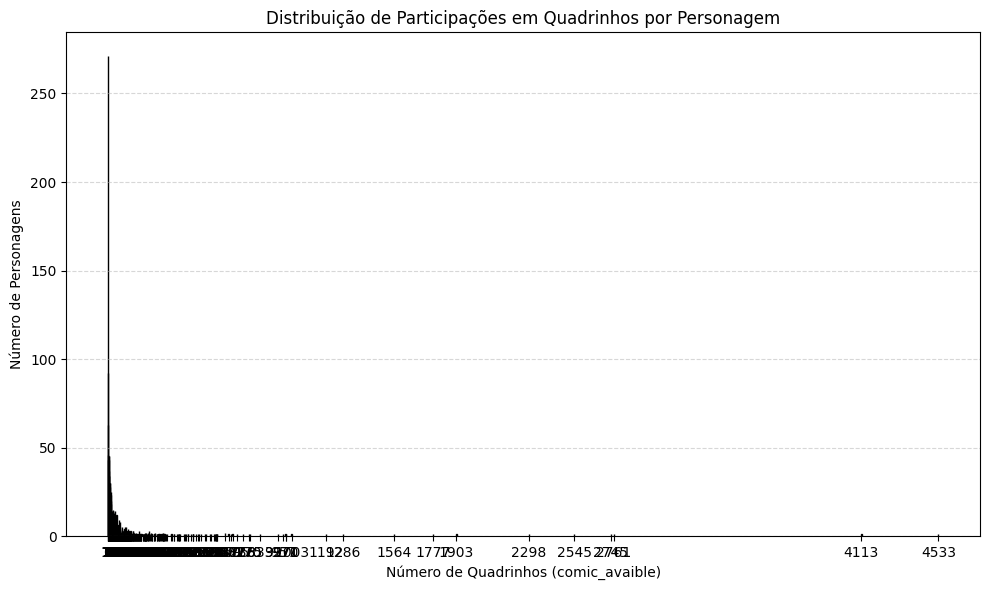

In [14]:
import matplotlib.pyplot as plt

# Supondo que df_characters foi carregado com a tabela characters
df_char['comic_avaible'] = pd.to_numeric(df_char['comic_avaible'], errors='coerce')
df_counts = df_char['comic_avaible'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(df_counts.index, df_counts.values, width=0.8, color='salmon', edgecolor='black')
plt.title('Distribuição de Participações em Quadrinhos por Personagem')
plt.xlabel('Número de Quadrinhos (comic_avaible)')
plt.ylabel('Número de Personagens')
plt.xticks(df_counts.index)  # Mostra somente inteiros no eixo X
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
